Import libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima

Load dataset and prepare df

In [30]:
# Load the dataset
file_path = '../data/owid-covid-data.csv'
date_column = 'date'
target_column = 'new_deaths'
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()

Determine whether the dataset is stationary

In [31]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df[target_column])

1. ADF :  -2.16407040266354
2. P-Value :  0.21954320991500131
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 1348
5. Critical Values :
	 1% :  -3.435210382964628
	 5% :  -2.8636864858936333
	 10% :  -2.5679127921571907


Parameter tuning for order

In [32]:
stepwise_fit = auto_arima(df[target_column], trace=True,
suppress_warnings=True)
best_order=stepwise_fit.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29138.397, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30173.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29819.963, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29311.010, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30171.461, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29255.887, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29286.441, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29052.392, Time=1.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29265.228, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29018.616, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=29167.831, Time=0.42 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=28997.290, Time=1.20 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=28822.459, Time=1.22 sec
 ARIMA(5,1,2)(0,0,0)[0] i

Plot ACF and PACF for ARIMA order identification

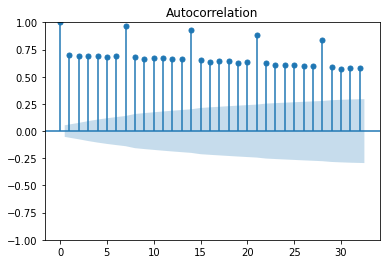

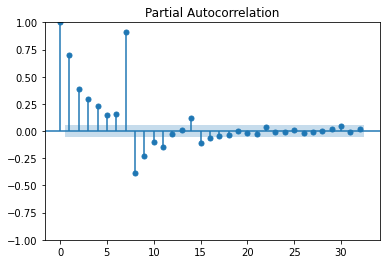

In [33]:
train = df[[target_column]].iloc[:-30]
test = df[[target_column]].iloc[-30:]
plot_acf(train)
plt.show()

plot_pacf(train)
plt.show()

Create Model

In [34]:
model=ARIMA(train[target_column],order=best_order)
model=model.fit()
model.summary()

c:\Users\ambro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                 1336
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -13939.214
Date:                Sun, 22 Oct 2023   AIC                          27900.428
Time:                        17:54:35   BIC                          27957.591
Sample:                             0   HQIC                         27921.847
                               - 1336                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0286      0.073      0.392      0.695      -0.115       0.172
ar.L2         -0.8253      0.065    -12.623      0.000      -0.953      -0.697
ar.L3         -0.3064      0.105     -2.917      0.004      -0.512      -0.101
ar.L4         -0.3684      0.063     -5.885      0.000      -0.491      -0.246
ar.L5         -0.7504      0.069    -10.901      0.000      -0.885      -0.615
ma.L1         -1.3182      0.087    -15.186      0.000      -1.488      -1.148
ma.L2          1.6061      0.143     11.245      0.000       1.326       1.886
ma.L3         -1.3244      0.159     -8.352      0.000      -1.635      -1.014
ma.L4          1.0012      0.101      9.878      0.000       0.803       1.200
ma.L5         -0.3783      0.080     -4.757      0.000      -0.534      -0.222
sigma2      1.438e+08   2.77e-09   5.18e+16      0.000    1.44e+08    1.44e+08
===================================================================================
Ljung-Box (L1) (Q):                  15.39   Jarque-Bera (JB):              9907.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+32. Standard errors may be unstable.
"""

Plot the result

c:\Users\ambro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

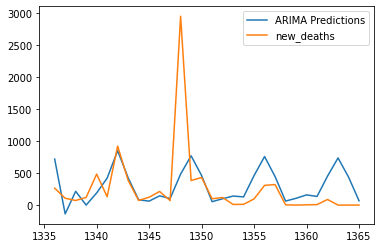

In [35]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test[target_column].plot(legend=True)

RMSE of the result

In [36]:

test[target_column].mean()
rmse=sqrt(mean_squared_error(pred,test[target_column]))
print(rmse)

518.6235701579877
